In [29]:
!pip3 install -r requirements.txt &> /dev/null

In [49]:
import pandas as pd
import wbgapi as wb # World Bank API
import pandasdmx as sdmx # UNICEF API
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from geopy.geocoders import GeoNames
from statsmodels.api import OLS, WLS
import pandasdmx as sdmx
import numpy as np
import plotly.express as px

# Prevalence Data

We pull data from our original [research compilation](https://docs.google.com/spreadsheets/d/1CggPY4jmicgPwr4yXQr9jnu4BOjSRL1jU1c43dH4BTI/edit?usp=sharing), the [World Bank](https://data.worldbank.org/), and [UNICEF](https://data.unicef.org/).

### Original Research

We compiled the largest existing database of field studies on the prevalence substandard and falsified medicines. We combined results from three of largest existing literature reviews, [McManus et al. (2020)](https://gh.bmj.com/content/5/8/e002393), [Ozawa et al. (2018)](https://pubmed.ncbi.nlm.nih.gov/30646106/), and [Kelesidis et al. (2015)](https://pubmed.ncbi.nlm.nih.gov/25788516/). We then conducted a manual search [PubMed](https://pubmed.ncbi.nlm.nih.gov/), [Google Scholar](https://scholar.google.com/), and [MEDLINE](https://www.nlm.nih.gov/medline/medline_overview.html) to fill gaps in evidence.

After cleaning, standardizing, and depublicating, the database spanned 177 unique studies spanning from 1992 to 2018. In addition to the country and estimated prevalence, each row documents a number of relevant methodological features. We aggregated these studies by country in Africa and weighted by sample size to produce a country-level database.

In [77]:
sheet_id = "1BE4MRIs8Uhnj2M4WR5HThuead49iwllkL1tk166uSW4" # Google Sheet ID

"""
Helper function for pulling Google Sheets tabs.
"""
def get_sheet(sheet_name):
  url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
  df = pd.read_csv(url, error_bad_lines=False, thousands = ",") # Ignore errors
  return df

orig_df = get_sheet("Africa") # Pull countries data

In [78]:
orig_df

,Country,Region,Population (2021),PMS Rating,McManus (2020) Studies,Kelesidis (2015) Studies,Ozawa (2017) Studies,Total Studies,Total Samples,Total Defective,Weighted Prevalence
0,Algeria,Northern Africa,43851044,0,0,0,0,0,0,0,NaN
1,Angola,Central Africa,36910560,1,1,4,6,0,0,0,NaN
2,Benin,Western Africa,12123200,0,2,0,1,0,0,0,NaN
3,Botswana,Southern Africa,2351627,2,0,1,0,0,0,0,NaN
4,Burkina Faso,Western Africa,20903273,4,0,1,4,2,38,4,10.61%
5,Burundi,Eastern Africa,11890784,0,0,1,0,0,0,0,NaN
6,Cabo Verde,Western Africa,555987,2,0,0,0,0,0,0,NaN
7,Cameroon,Central Africa,26545863,0,1,4,7,1,219,15,6.80%
8,Central African Republic,Central Africa,4829767,0,0,2,1,0,0,0,NaN
9,Chad,Central Africa,16425864,0,0,2,2,0,0,0,NaN


In [79]:
orig_df['Weighted Prevalence'] = orig_df['Weighted Prevalence'].str.rstrip('%').astype('float') / 100.0 # Fix percentage

In [150]:
target_countries = wb.economy.coder(orig_df['Country'])
target_countries[11] = "COG"
target_countries[13] = "COD"
target_countries[40] = "STP"
target_countries[39] = "ESH"
target_countries[46] = "SSD"
orig_df['Country Code'] = target_countries

In [151]:
orig_df[['Country Code', 'Country']]

,Country Code,Country
0,DZA,Algeria
1,AGO,Angola
2,BEN,Benin
3,BWA,Botswana
4,BFA,Burkina Faso
5,BDI,Burundi
6,CPV,Cabo Verde
7,CMR,Cameroon
8,CAF,Central African Republic
9,TCD,Chad


### World Bank

We collected 13 features from the [World Bank](https://data.worldbank.org/):
- [Population](https://data.worldbank.org/indicator/sP.POP.TOTL)
- [Government expenditure](https://data.worldbank.org/indicator/NE.CON.GOVT.CD) - Total, USD
- [GPD per capita](https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD) - In USD, PPP
- [Malaria](https://data.worldbank.org/indicator/SH.MLR.INCD.P3) - Incidence per 1,000 at risk
- [CPIA Corruption](https://data.worldbank.org/indicator/IQ.CPA.TRAN.XQ) - Transparency, accountability, and corruption in the public sector
- [CPIA Administration](https://data.worldbank.org/indicator/IQ.CPA.PADM.XQ) - Quality of public administration
- [CPIA Property](https://data.worldbank.org/indicator/IQ.CPA.PROP.XQ) - Property rights and rule-based governance
- [CPIA Budgeting](https://data.worldbank.org/indicator/IQ.CPA.FINQ.XQ) - Quality of Budgetary and Financial Management
- [HIV Children](https://data.worldbank.org/indicator/SH.HIV.INCD.14) - Total new infections, aged 0-14
- [HIV Adults](https://data.worldbank.org/indicator/SH.HIV.INCD) - Total new infections, aged 15-49
- [Urban Population](https://data.worldbank.org/indicator/SP.URB.TOTL.IN.ZS) - Percent of total
- [Disease](https://data.worldbank.org/indicator/SH.DTH.COMM.ZS) - Death by communicable disease, % of total
- [Health Expenditures](https://data.worldbank.org/indicator/SH.XPD.CHEX.PP.CD) - USD per capita, PPP
- [Aid](https://data.worldbank.org/indicator/DC.DAC.CECL.CD) - From DAC donors, USD

Using their [API](https://pypi.org/project/wbdata/), we queried and averaged 5 years of data to maximize avilability.

In [104]:
wb_indicators = {
    "NY.GDP.PCAP.CD":"GDP", # Per capita
    "SP.POP.TOTL":"Population",
    "NE.CON.GOVT.CD":"Government Expenditure", # Total
    "IQ.CPA.TRAN.XQ":"CPIA Corruption",
    "IQ.CPA.PADM.XQ":"CPIA Administration",
    "Q.CPA.PROP.XQ": "CPIA Property",
    "IQ.CPA.FINQ.XQ":"CPIA Budgeting",
    "SH.MLR.INCD.P3":"Malaria", # Per 1,000 at risk
    "SH.HIV.INCD.14":"HIV Children", # Total
    "SH.HIV.INCD":"HIV Adults", # Total
    "SP.URB.TOTL.IN.ZS":"Urban Population", # % of total
    "SH.DTH.COMM.ZS":"Infectious Disease", # % of total
    "SH.XPD.CHEX.PP.CD":"Healthcare Expenditure", # Per capita
    "DC.DAC.CECL.CD":"Aid", # Total
    "mpf.cri.the":"Crime and Theft"
}
wb_to_scale = [
    "Government Expenditure",
    "HIV Children",
    "HIV Adults",
    "Aid"
]

In [105]:
wb_raw_df = wb.data.DataFrame(wb_indicators.keys(),
    target_countries,
    mrv=3)

In [106]:
wb_average_df = wb_raw_df.mean(axis = 1).unstack(level=1).rename(columns=wb_indicators)

We also standardized features to be per-capita.

In [107]:
wb_final_df = wb_average_df.copy()
wb_final_df[wb_to_scale] = wb_final_df[wb_to_scale].div(wb_final_df.Population, axis = 0)
wb_final_df.shape

(54, 13)

### UNICEF

We collected 3 features from [UNICEF](https://data.unicef.org/):
- [HIV Rate](https://data.unicef.org/topic/hivaids/global-regional-trends/) - % of total
- [Vaccination Rate](https://data.unicef.org/topic/child-health/immunization/), % of total
- [Mortality Rate](https://data.unicef.org/topic/child-survival/under-five-mortality/) - Under 5, % of total

We used the panda [SDMX](https://pandasdmx.readthedocs.io/en/v1.0/) (Statistical Data and Metadata eXchange) library to pull the data, with significant processing.

In [57]:
# Establish connection to UNICEF
sdmx.list_sources()
unicef = sdmx.Request('UNICEF')

In [58]:
flow_msg = unicef.dataflow()
dataflows = sdmx.to_pandas(flow_msg.dataflow)
print(dataflows.head()) # Some of the dataflows of the UNICEF SDMX data

CAUSE_OF_DEATH                                      Cause of death
CCRI                 Children’s Climate and Environment Risk Index
CHILD_RELATED_SDG                          Child-related SDGs 2020
CHLD_PVTY                                            Child Poverty
CME                                                Child Mortality
dtype: object


In [108]:
# Get metadata about various UNICEF datasets
IMM_MSG = unicef.dataflow('IMMUNISATION')
HIV_MSG = unicef.dataflow('HIV_AIDS')
CME_MSG = unicef.dataflow('CME')
MCH_MSG = unicef.dataflow('MNCH')

In [109]:
# Get structure of immunisations and HIV/AIDS
imm_struct = IMM_MSG.dataflow.IMMUNISATION.structure
hiv_struct = HIV_MSG.dataflow.HIV_AIDS.structure
cme_struct = CME_MSG.dataflow.CME.structure
mch_struct = MCH_MSG.dataflow.MNCH.structure

In [110]:
# Query to see labels (dimensions), as well as indicators from which we determine some to use in analysis
print(imm_struct.dimensions.components)
print(imm_struct.measures.components)
indicators = sdmx.to_pandas(imm_struct.dimensions.get('INDICATOR').local_representation.enumerated)
print(indicators.head(30)) # Using CME_MRY5T14 Mortality rate (children aged 5 to 14 years)

[<Dimension REF_AREA>, <Dimension INDICATOR>, <Dimension VACCINE>, <Dimension AGE>, <TimeDimension TIME_PERIOD>]
[<PrimaryMeasure OBS_VALUE>]
                                                                  name  \
CL_UNICEF_INDICATOR                                                      
CME                                                    Child mortality   
CME_ARR_10T19        Annual Rate of Reduction in Mortality Rate Age...   
CME_ARR_SBR          Annual rate of reduction in stillbirth rate (o...   
CME_ARR_U5MR         Annual rate of reduction in under-five mortali...   
CME_MRM0                                       Neonatal mortality rate   
CME_MRY0                                         Infant mortality rate   
CME_MRY0T4                                   Under-five mortality rate   
CME_MRY10T14                                  Mortality rate age 10-14   
CME_MRY10T19                                  Mortality rate age 10-19   
CME_MRY15T19                                

In [112]:
# Query data using the retrieved data structure
imm_data = unicef.data('IMMUNISATION', 
                       key=dict(INDICATOR='IM_HPV'),
                       dsd=imm_struct)
imm_data = sdmx.to_pandas(imm_data)


hiv_data = unicef.data('HIV_AIDS', 
                       key=dict(INDICATOR='HVA_EPI_INF_RT_0-14',
                                AGE='_T',
                                SEX='_T',
                                WEALTH_QUINTILE='_T',
                                RESIDENCE='_T'), 
                       dsd=hiv_struct)
hiv_data = sdmx.to_pandas(hiv_data, dtype=np.character)
hiv_data = hiv_data[hiv_data != b'<0.01']
hiv_data = hiv_data.astype('float64')

cme_data = unicef.data('CME',
                       key=dict(INDICATOR='CME_MRY5T14',
                                SEX='_T',
                                WEALTH_QUINTILE='_T'))
cme_data = sdmx.to_pandas(cme_data)

In [113]:
from collections import defaultdict

# Averages the most recent 5 years of data from indicator Series data passed in
# For each country, averages the most 5 recent years' measurements of that indicator
# Takes in a Series object, returns a pandas Dataframe
def average_df(data, columns=None):
    dct = defaultdict(lambda: {})

    for k,v in data.iteritems():
        code, year = k[0], int(k[-1])
        dct[code][year] = v

    for k,v in dct.items():
        dct[k] = np.mean([x[1] for x in sorted(v.items(), key = lambda x: -x[0])[:5]])
    
    df = pd.DataFrame.from_dict(dct, orient='index', columns=columns)
    
    return df

In [114]:
# HIV, Code -> HVA_EPI_INF_RT_0-14 (percentage of children 0-14 with HIV treated with ART)
# IMM, Code -> IMM_HPV (percentage that are HPV vaccinated)
# CME, Code -> CME_MRY5T14 Mortality rate (children aged 5 to 14 years)
hiv_avg_data = average_df(hiv_data, columns=['HIV Rate']).fillna(0)
imm_avg_data = average_df(imm_data, columns=['HPV Vacinnation Rate'])
cme_avg_data = average_df(cme_data, columns=['Mortality Rate'])

In [115]:
unicef_df = pd.concat([hiv_avg_data, imm_avg_data, cme_avg_data], axis=1)

### Merge

We combine these data sources together on the country code.

In [120]:
final_df = orig_df.merge(wb_final_df, left_on = "Country Code", right_index = True)
final_df = final_df.merge(unicef_df, how = 'left', left_on = "Country Code", right_index = True)
final_df['Healthcare Expenditure Total'] = final_df['Healthcare Expenditure'] * final_df['Population']

In [121]:
output_file = 'output/africa_data.csv'
final_df.to_csv(output_file)

## DALYs

In [160]:
daly_file = 'data/daly.csv'
daly_df = pd.read_csv(daly_file)
daly_df

,Cause,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
0,NaN,AFG,ALB,DZA,AGO,ATG,ARG,ARM,AUS,AUT,...,TZA,USA,URY,UZB,VUT,VEN,VNM,YEM,ZMB,ZWE
1,NaN,"38,042","2,881","43,053","31,825",97,"44,781","2,958","25,203","8,955",...,"58,005","329,065","3,462","32,982",300,"28,516","96,462","29,162","17,861","14,645"
2,All Causes,16695.4,797.1,10508.5,16532.8,25.7,12251.9,863.8,6101.2,2517.5,...,22661.4,108567.2,1075.0,8390.1,109.9,8479.6,27592.7,11913.0,8447.2,6995.1
3,"I. Communicable, maternal, perinatal and nutri...",NaN,51.3,2209.0,10415.9,2.7,1638.1,79.3,261.0,91.9,...,13009.7,5729.4,76.9,1404.8,26.7,1594.6,4054.4,4787.3,5254.9,3733.4
4,A. Infectious and parasitic diseases,NaN,11.1,434.2,5063.8,1.2,441.7,18.1,71.3,27.6,...,6487.5,2136.4,27.8,332.7,9.2,625.3,1688.3,1396.2,2917.3,1986.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,8. Other unintentional injuries,NaN,9.0,116.3,196.0,0.9,257.8,14.5,111.3,41.9,...,324.8,1394.6,23.2,137.1,1.8,117.5,262.6,168.4,123.1,104.4
213,B. Intentional injuries,NaN,12.5,138.1,355.3,0.2,374.4,10.1,176.1,52.5,...,410.3,3675.4,50.5,190.2,3.7,1005.0,461.4,1232.0,141.0,221.5
214,1. Self-harm,NaN,5.4,57.8,87.3,0.0,188.4,3.5,142.0,46.8,...,109.4,2379.7,32.0,153.5,3.1,29.5,308.4,98.2,60.0,95.3
215,2. Interpersonal violence,NaN,6.3,58.8,185.6,0.2,181.2,6.4,33.6,5.6,...,298.2,1228.1,18.5,36.0,0.6,963.1,150.9,186.3,80.5,124.1


In [161]:
daly_df = daly_df.set_index('Cause')
select = daly_df.iloc[0].isin(target_countries)
daly_df = daly_df[select.index[select]]
daly_df = daly_df.iloc[2:]
daly_df.head()

,Algeria,Angola,Benin,Botswana,Burkina Faso,Burundi,Cabo Verde,Cameroon,Central African Republic,Chad,...,Somalia,South Africa,South Sudan,Sudan,Togo,Tunisia,Uganda,United Republic of Tanzania,Zambia,Zimbabwe
Cause,,,,,,,,,,,,,,,,,,,,,
All Causes,10508.5,16532.8,6425.8,1111.5,11109.7,5395.7,134.6,13540.7,3593.3,11070.3,...,11624.4,27300.7,6403.3,15954.4,3720.6,2965.2,16708.1,22661.4,8447.2,6995.1
"I. Communicable, maternal, perinatal and nutritional conditions",2209.0,10415.9,3850.3,557.8,6741.2,3019.8,27.3,7805.2,2376.3,7596.4,...,7949.8,11183.6,4267.0,7309.4,2059.1,356.6,9379.2,13009.7,5254.9,3733.4
A. Infectious and parasitic diseases,434.2,5063.8,1882.4,366.8,3342.1,1361.7,9.1,4246.8,1378.8,3508.1,...,3841.3,7516.9,2160.5,2799.4,1074.9,78.1,4870.7,6487.5,2917.3,1986.0
1. Tuberculosis,159.9,944.3,57.6,35.2,125.2,150.7,1.5,423.9,265.2,207.4,...,560.9,1268.2,195.4,212.5,19.1,8.7,479.4,1049.0,354.9,132.7
2. STDs excluding HIV,10.2,124.4,16.5,4.0,32.4,8.2,0.5,113.3,11.8,68.3,...,37.1,127.9,34.2,60.9,10.5,3.6,212.0,204.5,84.6,16.0


In [167]:
for column in daly_df.columns:
    daly_df[column] = pd.to_numeric(daly_df[column], errors='coerce')

In [173]:
sums = daly_df.sum(axis=1).round(1)
sums.to_csv('output/africa_daly.csv')

# Mapping

In [118]:
map_df = get_sheet("LMICs") # Pull countries data

In [119]:
map_df['Weighted Prevalence'] = map_df['Weighted Prevalence'].str.rstrip('%').astype('float') / 100.0 # Fix percentage
target_countries = wb.economy.coder(map_df['Country'])
map_df['Country Code'] = target_countries

In [24]:
map_df.at[103, "Country Code"] = "COG" # Republic of Congo
map_df.at[31, "Country Code"] = "COD" # DR Congo
map_df.at[118, "Country Code"] = "SDS" # South Sudan

We write a helper to query the center of each country.

In [25]:
"""
Get latitudes of longitudes.
"""
geolocator = GeoNames(username = "sydneydegen1")
def geolocate(country):
        # Geolocate the center of the country
      loc = geolocator.geocode(query=country)
      # And return latitude and longitude
      return (loc.latitude, loc.longitude) if loc else (0,0)

map_df[["Latitude", "Longitude"]] = map_df["Country"].apply(geolocate).apply(pd.Series)

options = list(map_df.columns)

In [ ]:
map_feature = 'Weighted Prevalence'

In [ ]:
map_feature = "Weighted Prevalence"
viz_df = map_df[map_df[map_feature].notna()]
prev_map = folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(prev_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(viz_df)):
        if viz_df.iloc[i]['Latitude']:
            lat = viz_df.iloc[i]['Latitude']
            lng = viz_df.iloc[i]['Longitude']
            radius = 3
            popup_text = """Country : {}<br>
                            {} : {}<br>"""
            popup_text = popup_text.format(viz_df.iloc[i]['Country'],
                                    map_feature,
                                    viz_df.iloc[i][map_feature]
                                    )
            folium.CircleMarker(location = [lat, lng], radius=radius, popup= popup_text, fill =True, color="#000000").add_to(marker_cluster)

In [ ]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json'
prev_map.choropleth(
    geo_data=country_shapes,
    name='choropleth',
    data=viz_df,
    columns=['Country Code', map_feature],
    key_on='feature.id',
    fill_color='YlGn',
    landcolor = 'white',
    fill_opacity=0.7,
    line_opacity=0.2,
)
prev_map

/shared-libs/python3.7/py/lib/python3.7/site-packages/folium/folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


# Analysis

## Correlation Matrix

We made a correlation coefficient between each of the features and made several observations:
1. GDP, healthcare expenditure, and government expenditure are negatively associated with most forms of morbidity and mortality.
2. A higher rating on CPIA measures correlates with a higher regulatory rating and lower prevalence of SFMs.
3. Regions with greater morbidity also have fewer studies and lower populations.

<AxesSubplot:>

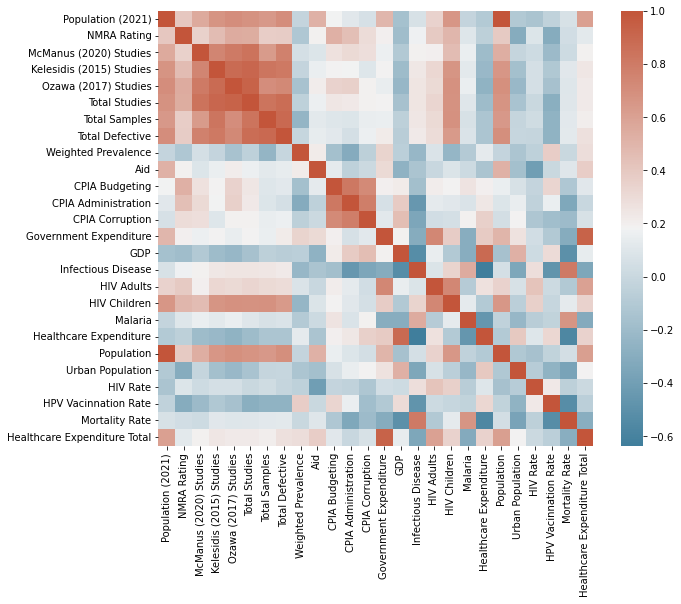

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
corr = final_df.corr()
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Plot heatmap
sns.heatmap(corr, cmap=cmap, square=True, ax=ax)

## Governance and Prevalence

We setup a multiple regression model to predict prevalence from broad demographic and governance factors. Formally, the model was:

$\text{Prev.} \sim \text{GDP}+ \text{NMRA Rating} + \text{Health Exp.} + \text{Gov. Exp.} + \text{Budget} + \text{Admin} + \text{Corrup} + \text{Ugban Pop.}$

In [ ]:
"""
Train a linear regression mode.
"""
def make_model(df, predictors, outcome, weights = None):
    new_df = df[predictors + [outcome] + [weights]].dropna()
    print("Observations", len(new_df))
    X = new_df[predictors]
    y = new_df[outcome]
    if weights:
        w = new_df[weights]
        model = WLS(y, X, w)
    else:
        model = OLS(y, X)
    return model.fit()

In [ ]:
predictors = ["GDP",
              "NMRA Rating",
              "Healthcare Expenditure",
              "Government Expenditure",
              "CPIA Budgeting",
              "CPIA Administration",
              "CPIA Corruption",
              "Urban Population"]
outcome = "Weighted Prevalence"
weights = "Population"
result = make_model(final_df, predictors, outcome, weights)
print(result.params)
print(result.tvalues)

Observations 26
GDP                      -3.457239e-05
NMRA Rating              -3.432383e-03
Healthcare Expenditure    4.052578e-04
Government Expenditure   -4.164746e-12
CPIA Budgeting            1.094523e-01
CPIA Administration      -1.194213e-01
CPIA Corruption           7.752246e-02
Urban Population          1.206054e-03
dtype: float64
GDP                      -0.496084
NMRA Rating              -0.478924
Healthcare Expenditure    0.816395
Government Expenditure   -1.124873
CPIA Budgeting            1.284614
CPIA Administration      -1.423182
CPIA Corruption           1.146845
Urban Population          0.693726
dtype: float64


## Mortality and Morbidity

We regressed various measures of mortality and morbidity against weighted prevalence, controlling for GDP per capita.

### Child Mortality

In [ ]:
predictors = ["Weighted Prevalence",
              "GDP"]
outcome = "Mortality Rate"
result = make_model(final_df, predictors, outcome)
print(result.params)
print(result.tvalues)

KeyError: "['Mortality Rate', None] not in index"

In [ ]:
fig = px.scatter(final_df,
        x="Weighted Prevalence",
        y="Mortality Rate",
        size="Population (2021)",
        color="Region",
        text="Country",
        trendline="ols",
        trendline_scope="overall")
fig.update_layout(title='SFM Prevalence and Child Mortality')
fig.show()

### Malaria Incidence

In [ ]:
predictors = ["Weighted Prevalence",
              "GDP"]
outcome = "Malaria"
result = make_model(final_df, predictors, outcome)
print(result.params)
print(result.tvalues)

KeyError: '[None] not in index'

In [ ]:
fig = px.scatter(final_df,
        x="Weighted Prevalence",
        y="Malaria",
        size="Population (2021)",
        color="Region",
        text="Country")
fig.update_layout(title='SFM Prevalence and Malaria')
fig.show()

### HIV Incidence

In [ ]:
predictors = ["Weighted Prevalence",
              "GDP"]
outcome = "HIV Children"
result = make_model(final_df, predictors, outcome)
print(result.params)
print(result.tvalues)

NameError: name 'make_model' is not defined

In [ ]:
fig = px.scatter(final_df,
        x="Weighted Prevalence",
        y="HIV Children",
        size="Population (2021)",
        color="Region",
        text="Country")
fig.update_layout(title='SFM Prevalence and HIV Children')
fig.show()

### Infectious Disease

In [ ]:
predictors = ["Weighted Prevalence",
              "GDP"]
outcome = "Infectious Disease"
result = make_model(final_df, predictors, outcome)
print(result.params)
print(result.tvalues)

KeyError: '[None] not in index'

In [ ]:
fig = px.scatter(final_df,
        x="Weighted Prevalence",
        y="Infectious Disease",
        size="Population (2021)",
        color="Region",
        text="Country",
        trendline="ols",
        trendline_scope="overall")
fig.update_layout(title='SFM Prevalence and Infectious Disease')
fig.show()

In [ ]:
final_df['Healthcare Expenditure Total'] = final_df['Healthcare Expenditure'] * final_df['Population']

In [ ]:

fig = px.scatter(final_df,
        x="Healthcare Expenditure Total",
        y="Infectious Disease",
        color="Region",
        trendline="ols",
        trendline_scope="overall")
fig.update_layout(title='Healthcare Expenditure by Country and Total SFM Studies')
fig.show()

# Conclusion

The project yielded several interesting insights. We confirmed our intuitions that SFM prevalence is associated with increased morbidity and mortality. As expected, various indicators of good governance are correlated with lower rates of SFMs. The overall picture is that SFMs are a serious threat to the UN's health development goals and can be redressed through better funding for good governance.

Our project faced several limitations, which each could represent next steps:
1. The underlying prevalence data often were based on only a handful of studies for each country, which could lead to inaccurate results for understudied countries. This is particularly true for countries like South Africa, where as single study found an unexpectedly high rate of SFMs in a small sample. Conducting and incorporating more field studies would enable better estimates.
2. The statistical techniques deployed cannot establish causal relationships. Data on intermediary steps (e.g. Malaria hospitalizations, recovery rates) could better make a case for causal impacts, and time-series data could lend itself to causal inference.
3. The predictors were often incomplete, forcing us to use subsets of data for regression. A more complete set of indicators would provide greater statistical power.
4. The regressions did not weight data points for population. Such a step could mitigate the lack of data and improve accuracy.

On reflection, we enjoyed conducting this project and learned a lot about APIs, visualization techniques, and DeepNote. We look forward to sharing the results and contributing to a real-world solution! 🎉

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5664658e-cfd9-4f94-8506-ba2a3813b000' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>